# MODELO ANOVA

## Realizado por: Pablo Sánchez Cabrera

Se cargan las librerías:

In [14]:
import time
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf  #sintáxis análoga a R
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot

import warnings
warnings.filterwarnings("ignore")

Se cargan los datos de `mtcars`. Estos datos están ya disponibles en la librería **statsmodels**.

In [15]:
mtcars = sm.datasets.get_rdataset("mtcars", "datasets", cache=True).data
mtcars.head(10)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


## Análisis de la Varianza de un factor

Se analizan los niveles de potencia en función del número de cilindros de los automóviles.

En primer lugar, se grafica un `box-plot`:

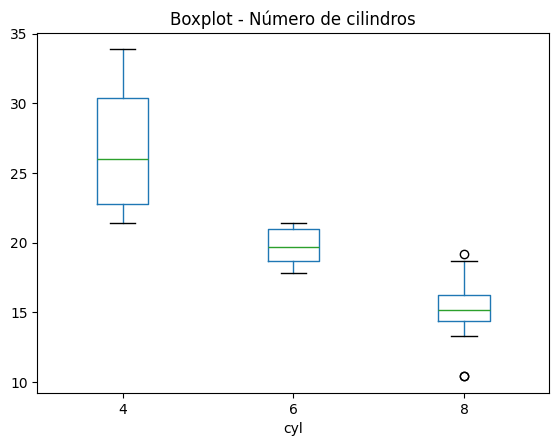

In [16]:
#Medias: potencia
#Grupo: número de cilindros
boxplot = mtcars.boxplot('mpg', by='cyl', grid=False) #pintamos boxplot 
plt.title('Boxplot - Número de cilindros')
plt.suptitle('') 
plt.show()

Se observan claras diferencias entre grupos. Creamos el modelo y la tabla anova para conocer si las diferencias muestrales son significativas 

#### Contraste de hipótesis

`Levene (iguadad de varianzas y Residuos)`

Existen 3 niveles: 4, 6 y 8 cilindros

Vamos a definir una función **get_levene_test_type_cylindres** que nos servirá para ser reutilizada más adelante:

In [17]:
def get_levene_test_type_cylindres(table: pd.DataFrame, target: str = "mpg"):
    """
    Método que calcula el Test de Levene para una variable cuantitativa (por defecto `mpg`)
    Variable categórica a analizar (nº de cilindros / cyl)
    """
    d = {} # diccionario
    # bucle para añadir al diccionario el consumo de los automóviles según el número de cilindros
    for n_cyl in table['cyl'].unique():
        data = table.loc[table['cyl'] == n_cyl][target]
        d[f"n_cyl_{str(n_cyl)}"] = data  # la clave es un texto: "n_cyl_X" donde x es 4, 6 u 8
        print(f"Número de cilindros: {n_cyl} - dataframe cargado en el diccionario")
        
    #Test de Igualdad de medias -> Levene 
    test_levene, p_value = stats.levene(d["n_cyl_6"], d["n_cyl_4"], d["n_cyl_8"], center='mean')
    print('Valor y p-value:', round(test_levene, 4), round(p_value, 4))
    del d # se elimina el diccionario al final

In [18]:
get_levene_test_type_cylindres(mtcars)

Número de cilindros: 6 - dataframe cargado en el diccionario
Número de cilindros: 4 - dataframe cargado en el diccionario
Número de cilindros: 8 - dataframe cargado en el diccionario
Valor y p-value: 6.4843 0.0047


#### Modelo Anova

In [19]:
anova_mtcars = smf.ols('mpg ~ C(cyl)', data=mtcars).fit()  #C para identificar el factor
print(anova_mtcars.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     39.70
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           4.98e-09
Time:                        11:28:28   Log-Likelihood:                -81.282
No. Observations:                  32   AIC:                             168.6
Df Residuals:                      29   BIC:                             173.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      26.6636      0.972     27.437      

Puede verse que la forma de definir el modelo en **statsmodels** es similar a la de los paquetes de **R**. En este caso, se identifica el factor con la letra *C* (variable categórica)

#### Tabla Anova

In [20]:
tabla_anova = sm.stats.anova_lm(anova_mtcars, typ=2)
print(tabla_anova)

              sum_sq    df          F        PR(>F)
C(cyl)    824.784590   2.0  39.697515  4.978919e-09
Residual  301.262597  29.0        NaN           NaN


A raíz de los resultados vemos que:
- Tabla Anova: no hay igualdad de medias -> p-value de F es mucho menor que nivel de significancia
- Modelo Anova: las medias de cyl son: 26,66 para cyl=4; 19,74 para cyl=6 y 15,1 para cyl=8 (se apreciaba en box-plot)

Como el test de Levene mostró que la igualdad de varianzas no podía aceptarse (p-value<0.05) se pueden tomar logaritmos sobre la variable `mpg` para ver si se consigue esa normalidad necesaria para cumplir la hipótesis básica del modelo.

In [21]:
#Para conseguir igualdad de varianzas -> podemos tomar logaritmos
mtcars_log = mtcars.copy() # se copia el dataframe en nuevo objeto, suele ser lo más adecuado
mtcars_log['mpg'] = np.log(mtcars_log['mpg'])
mtcars_log.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,3.044522,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,3.044522,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,3.126761,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,3.063391,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,2.928524,8,360.0,175,3.15,3.440,17.02,0,0,3,2


Como puede verse se han modificado los valores de la variable `mpg`.

#### Modelo anova (logaritmos)

In [22]:
anova_mtcars_log = smf.ols('mpg ~ C(cyl)', data=mtcars_log).fit()  #C para identificar el factor
print(anova_mtcars_log.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     39.31
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           5.52e-09
Time:                        11:28:28   Log-Likelihood:                 14.849
No. Observations:                  32   AIC:                            -23.70
Df Residuals:                      29   BIC:                            -19.30
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2705      0.048     67.873      

#### Tabla anova (logaritmos)

In [23]:
tabla_anova_log = sm.stats.anova_lm(anova_mtcars_log, typ=2)
print(tabla_anova_log)

            sum_sq    df         F        PR(>F)
C(cyl)    2.008078   2.0  39.31247  5.521202e-09
Residual  0.740659  29.0       NaN           NaN


`Test de Levene`

Volvemos a usar la función anterior:

In [24]:
get_levene_test_type_cylindres(table=mtcars_log)

Número de cilindros: 6 - dataframe cargado en el diccionario
Número de cilindros: 4 - dataframe cargado en el diccionario
Número de cilindros: 8 - dataframe cargado en el diccionario
Valor y p-value: 1.6622 0.2073


`Test normalidad residuos -> Lilliefors`

De igual forma al caso anterior, se define una función:

In [27]:
def get_norm_test(table: pd.DataFrame, level: str = "cyl", target: str = "mpg"):
    # bucle para obtener el test de normalidad para el consumo según cada estrato (automóvil con nº cilindros diferente)
    for n_level in table[level].unique():
        print(f"Id level: {n_level}")
        data = table.loc[table[level] == n_level][target]
        # usando método gráfico
        qqplot=sm.qqplot(data, line='q') #qqplot
        plt.title(f'QQplot - {level}_{str(n_level)}')
        plt.show()

        # time.sleep(3)

        # se calcula del test
        test_normal, p_value=sm.stats.diagnostic.lilliefors(data)
        print('Valor y p-value:', round(test_normal, 3), round(p_value, 2))
        
        del data

Id level: 6


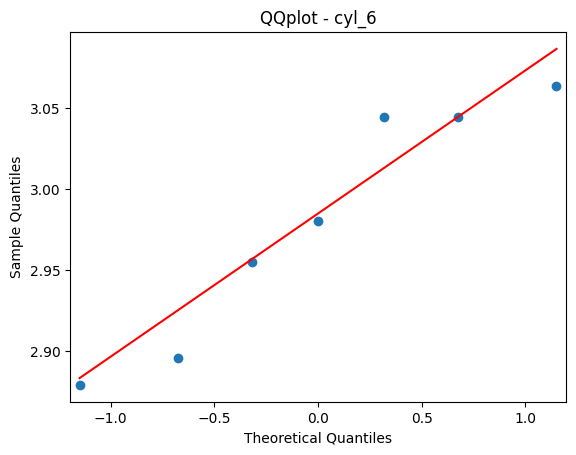

Valor y p-value: 0.234 0.31
Id level: 4


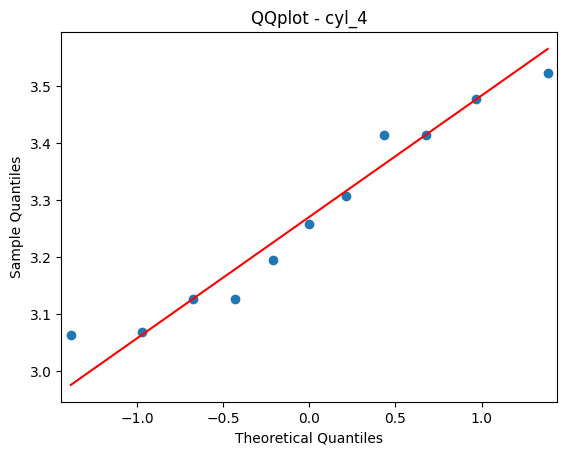

Valor y p-value: 0.168 0.51
Id level: 8


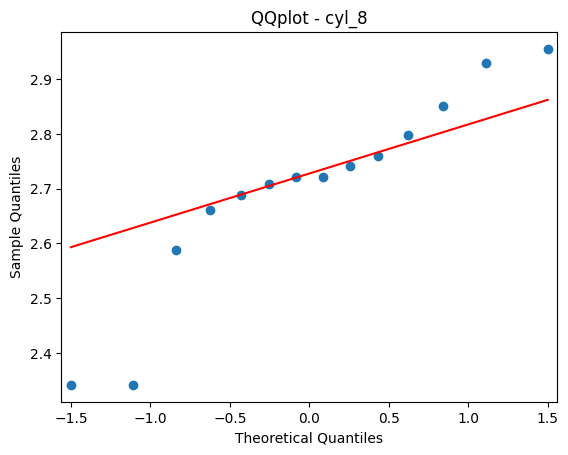

Valor y p-value: 0.199 0.15


In [28]:
get_norm_test(mtcars_log)

## Análisis de la Varianza de dos factores

Se analizan los niveles de potencia en función del número de cilindros de los automóviles y el tipo de transmisión.

En primer lugar, se grafica un `box-plot` para el tipo de transmisión (el análisis con el número de cilindros ya se hizo en el punto anterior):

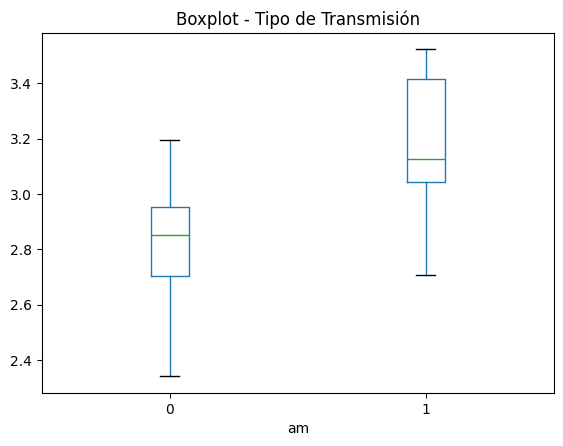

In [29]:
mtcars_log.boxplot('mpg', by='am', grid=False) #boxplot 
plt.title('Boxplot - Tipo de Transmisión')
plt.suptitle('') 
plt.show()

Puede verse que hay claras diferencias entre ambos grupos. 

#### Contraste de hipótesis

`Levene (iguadad de varianzas y Residuos)`

Existen 2 niveles: 0 y 1

In [30]:
data1 = mtcars_log.loc[mtcars['am'] == 0]
data2 = mtcars_log.loc[mtcars['am'] == 1]

#Test de Igualdad de medias -> Levene
test_levene, p_value =stats.levene(data1['mpg'], data2['mpg'], center='mean')
print('Valor y p-value:', round(test_levene, 3), round(p_value, 3))

Valor y p-value: 0.465 0.5


`Test normalidad residuos -> Lilliefors`

Id level: 1


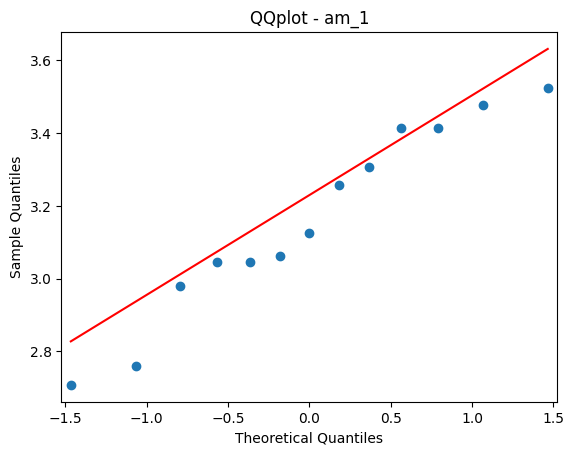

Valor y p-value: 0.138 0.7
Id level: 0


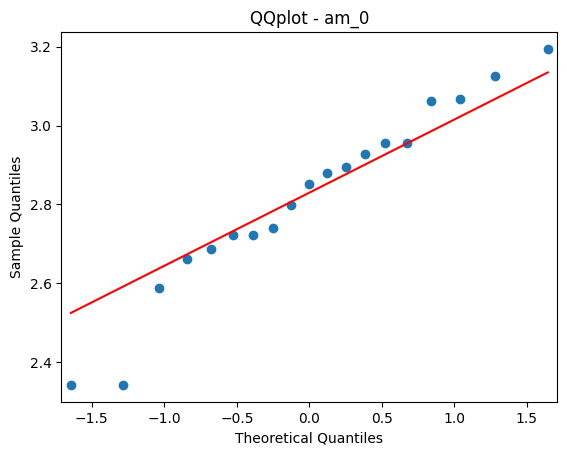

Valor y p-value: 0.095 0.92


In [31]:
get_norm_test(table=mtcars_log, level="am")

#### Modelo anova (logaritmos)

In [32]:
anova_mtcars_log_2e = smf.ols('mpg ~ C(cyl) + C(am) + C(cyl):C(am)', data=mtcars_log).fit()  #C para identificar el factor
print(anova_mtcars_log_2e.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     16.90
Date:                Sat, 02 Dec 2023   Prob (F-statistic):           1.89e-07
Time:                        11:29:26   Log-Likelihood:                 17.018
No. Observations:                  32   AIC:                            -22.04
Df Residuals:                      26   BIC:                            -13.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

#### Tabla Anova

In [33]:
tabla_anova_log_2e = sm.stats.anova_lm(anova_mtcars_log_2e, typ=2)
print(tabla_anova_log_2e)

                sum_sq    df          F    PR(>F)
C(cyl)        1.148677   2.0  23.088386  0.000002
C(am)         0.068081   1.0   2.736836  0.110083
C(cyl):C(am)  0.025811   2.0   0.518810  0.601261
Residual      0.646767  26.0        NaN       NaN


A la vista de los resultados, hay igualdad de medias en el tipo de transmisión. 

El uso del gráfico de interación también es adecuado para comprobar si existe o no interacción. 

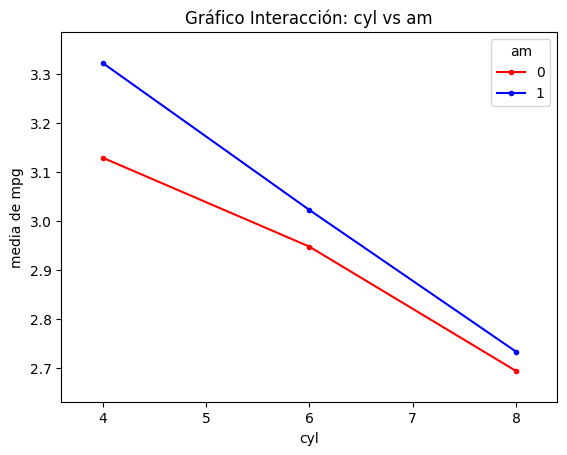

In [34]:
fig = interaction_plot(mtcars_log['cyl'], mtcars_log['am'], mtcars_log['mpg'], colors=['red','blue'])
plt.title('Gráfico Interacción: cyl vs am'), plt.ylabel('media de mpg')
plt.show()